# Motion magnification: under the hood
This notebook explains the inner workings motion magnification code, and demonstrates the effect of parameters `k` and `width`.

In [ ]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

First, let us create a numpy datacube containing a ring which oscillates from side to side. This will serve as a good test to show clearly what the MM is doing.

In [ ]:
# Define the dimensions of the array. Small to make MM quick!
width, height = 100, 100
nframes = 200

# Create an empty array with the specified dimensions
frames = np.zeros((nframes, width, height))

# Oscillation parameters
radius = 10   # inner radius of ring in pixels. Ring will have width of 1 pixel.
period = 50   # period in frames
amplitude = 0.5 # oscillation amplitude in pixels
thick = 2    # thickness of ring in pixels

# Generate the frames
for frame in range(nframes):
    # Calculate the center position of the circle based on the frame index
    # The circle oscillates horizontally with a period of 10 frames
    center_x = float(width / 2 + amplitude * np.sin(2 * np.pi * frame / period))
    center_y = float(height / 2)

    # Create a meshgrid of coordinates
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    # Calculate the distance from each point to the center of the circle
    distance = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)

    # Assign a value of 1 to points inside the circle
    frames[frame][(distance >= radius) & (distance <= radius + thick)] = 1

## Plot all the frames
#plt.figure(figsize=(8, 8))
#for frame in range(200):
#    plt.subplot(10, 20, frame + 1)
#    plt.imshow(frames[frame], cmap='gray', vmin=0, vmax=0.1) # make easier to see
#    plt.axis('off')
#
#plt.tight_layout()
#plt.show()

If you like, we can plot a subsection of frames to see the oscillation.

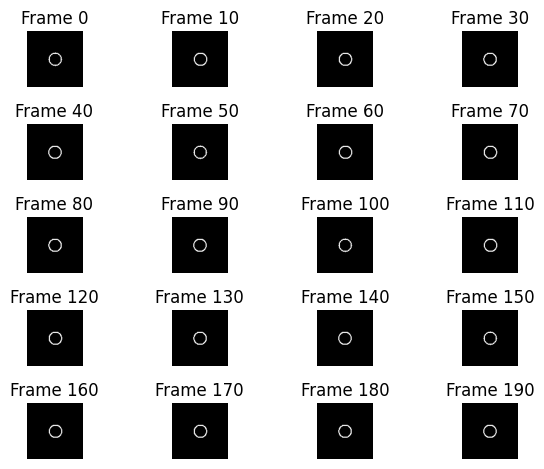

In [ ]:
# Determine the number of rows and columns in the grid
num_rows = 5
num_cols = 4

# Calculate the number of frames to plot
num_frames = float(num_rows * num_cols)
ntp = np.floor(200 / num_frames)

for i, frame in enumerate(range(0, 200, int(ntp))):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(frames[frame], cmap='gray')
    plt.title('Frame {}'.format(frame))
    plt.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

Now we make a function to do a quick animation of the datacube.
This assumes time is the first dimension, i.e. nframes = cube_array.shape[0]. \\
Please forgive my poor Python skills!

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate_cube(cube_array, cut=True, mn=0, sd=0, interval=75, cmap='gray', plot_cbar=True):
    '''
    animate a python datacube for quick visualisation. Colourbar range of 6 standard deviations around mean unless specified.

    INPUT:
        cube_array  : name of 3D numpy array that needs to be animated, with nframes being 1st dimension.
        cut         : trim #pixels off of the image's edge to remove edge detector effects.
                      Note default = True since 0 returns empty array(?!).
        mn          : mean of the cube | Used for contrast
        sd          : std of the cube  | Used for contrast
        interval    : #of ms between each frame.
        cmap        : colormap. Default='gray', consider 'hot'
        plot_cbar   : set to False to not show colourbar.

    OUTPUT:
        animated window going through the cube.

    '''

    fig = plt.figure()
    std = np.std(cube_array[0])
    mean = np.mean(cube_array[0])
    if mn==sd and mn==0:
        img = plt.imshow(cube_array[0][cut:-cut, cut:-cut], animated=True, vmax=mean+3*std, vmin=mean-3*std, cmap=cmap)
    else:
        img = plt.imshow(cube_array[0][cut:-cut, cut:-cut], animated=True, vmax=mn+3*sd, vmin=mn-3*sd, cmap=cmap)

    def updatefig(i):
        img.set_array(cube_array[i][cut:-cut, cut:-cut])
        return img,

    ani = FuncAnimation(fig, updatefig, frames=cube_array.shape[0],                                  interval=interval, blit=True)
    if plot_cbar==True:
        plt.colorbar()

    # Set up the HTML video player
    video = HTML(ani.to_jshtml())

    # Display the video player
    display(video)
    plt.show()
    # ani.save('cube_movie.avi', writer="ffmpeg", fps=15)
plt.show()

In [ ]:
animate_cube(frames, plot_cbar=False)

Output hidden; open in https://colab.research.google.com to view.

Now we get to the good bit: **motion magnification**! We need the Dual Tree Complex Wavelet Transform library, and the MM algorithm we will use based on it, from our colleague [Sergey Anfinogentov's github](https://github.com/Sergey-Anfinogentov/motion_magnification.git).

In [ ]:
%pip install dtcwt
!git clone https://github.com/Sergey-Anfinogentov/motion_magnification.git
%cd /content/motion_magnification
from magnify import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.8/70.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dtcwt: filename=dtcwt-0.12.0-py3-none-any.whl size=87869 sha256=ced6504315efed4cac45f6e0d7389a69e69f6ac7f6fdd7fe2122a647cb1f5d66
  Stored in directory: /root/.cache/pip/wheels/af/50/50/cf98b0e08812889d0f5789d271acbdab7ac7c3086c323a8e0a
Successfully built dtcwt
Cloning into 'motion_magnification'...
remote: Enumerating objects: 65, done.
remote: Total 65 (delta 0), reused 0 (delta 0), pack-reused 65
Unpacking objects: 100% (65/65), 13.17 KiB | 749.00 KiB/s, done.
/content/motion_magnification


Let us motion magnify this data. Very simply...

In [ ]:
k = 5      # Pick a magnification factor
width= 120 # width
frames_k5w120 = magnify_motions_2d(frames, k, width)

Forward DTCWT... DONE
Modifying phase... DONE
Inverse DTCWT... DONE


In [ ]:
animate_cube(frames_k5w120, plot_cbar=False)

Output hidden; open in https://colab.research.google.com to view.

Clearly we have magnified the oscillation! We can take a quick look at a "time distance plot" - just a cut of pixels through the centre.

(-0.5, 199.5, 99.5, -0.5)

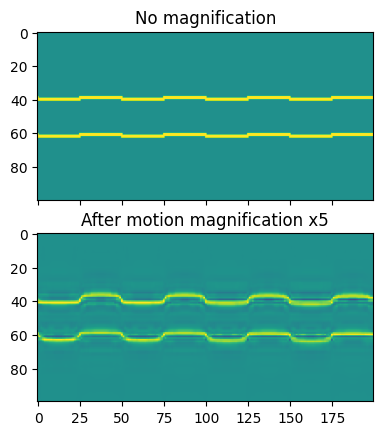

In [ ]:
frames_k5w120.shape
td_orig = np.transpose(frames[:,50,:])
td_k5w120 = np.transpose(frames_k5w120[:,50,:])

f, axarr = plt.subplots(2, sharex=True)
axarr[0].imshow(td_orig, vmin=-1., vmax=1.)
axarr[0].set_title('No magnification')
axarr[0].axis("tight")
axarr[0].set_ylabel("Pixel")
axarr[0].axis("image")
axarr[1].imshow(td_k5w120, vmin=-1., vmax=1.)
axarr[1].set_title('After motion magnification x5')
axarr[1].axis("tight")
axarr[1].set_ylabel("Pixel")
axarr[1].set_xlabel("Time")
axarr[1].axis("image")

It is clear to see that the oscillation is more visible after motion magnification, whilst the period remains the same.

Now that we have seen how the MM is implemented, let us dig into the detail. You can see that there are only 2 parameters we need for this function.

# Magnification factor `k`
This is simply the factor by which we will scale the phases in our specified period band, which will amplify any coherent displacements with periods lying within this band.

\\
Thinking about what the magnification is doing "under the hood", every wavelet component (in the 6 directions and for each scale) only `feels' the intensity distribution near its own position, within the size of the envelope of the mother wavelet. When we change the phases, we modify the reconstructed image but *only* in the local spatial neighbourhood of that component. We can not 'move' this component beyond the envelope of the mother wavelet (remember we leave the component's absolute value alone). Thus there is an upper limit on how much we can amplify motions. Trying to move beyond this limit will try to translate signal beyond where the absolute value is constant, losing the linear scaling property whilst also leading to distortion.

\\
In the solar case, when using a wide period band + short filter banks whilst searching for oscillation amplitudes $\lt$ 5 pixels, we can not push the amplification too far (see below for [Fig. 3a Anfinogentov & Nakariakov 2016](http://link.springer.com/10.1007/s11207-016-1013-z)). Further analysis of the signal will benefit from less distortion of features, so I recommend keeping `k` as small as possible while still highlighting previously hidden features.
In my experience, `k=5` is a good starting point when initially searching for decayless oscillations in solar data.

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


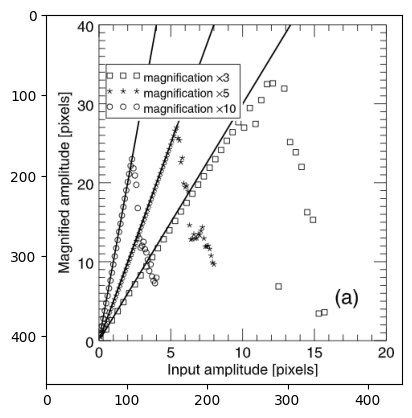

In [ ]:
import cv2
from google.colab import drive
drive.mount('/content/gdrive')

Anfinogentov2016_scaling = cv2.imread("/content/gdrive/MyDrive/Anfingentov2016_MM_fig3_scaling.PNG")
plt.figure(1)
plt.imshow(Anfinogentov2016_scaling)
plt.axis('off')

# Smoothing window width `w`
This is a period (in frames) which determines the length of the filter applied to the phases which are amplified during MM. Any oscillations with periodicity less than `w` should be linearly amplified by the motion magnification.
This parameter **must** be greater than the periodicity of the signal of interest.

Since we do not know exactly what oscillation period we are looking for, we must ensure we stay in the regime where the period scaling is the same for all periods. As you can see from the (figure below [Fig. 3b Anfinogentov & Nakariakov 2016](http://link.springer.com/10.1007/s11207-016-1013-z)), the scaling is not perfectly linear for very short oscillations. Further, recall the MM has a 2-frame smoother on the amplified phases. Thus one must be careful when oscillations appear at very short periods ($\lt$10 frames) and check they are not artefacts... thank goodness for the time resolution of SoLO/HRI!

Nonetheless it is worth stressing, it is **remarkable** how we can enhance *all* periodic signals less than the smoothing width linearly using the MM algorithm.

In my experience, using a smoothing width greater than or equal to 120 frames for 12 second cadence SDO/AIA data works well.

(-0.5, 438.5, 458.5, -0.5)

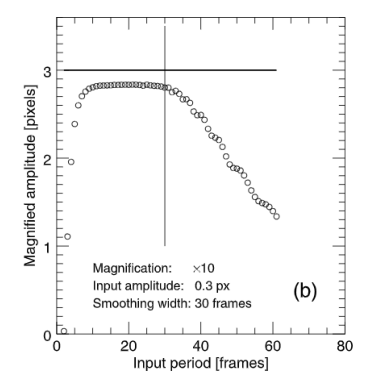

In [ ]:
Anfinogentov2016_width = cv2.imread("/content/gdrive/MyDrive/Anfingentov2016_MM_fig3_width.PNG")
plt.figure(2)
plt.imshow(Anfinogentov2016_width)
plt.axis('off')

# Potency of MM in sub-pixel regime

Another remarkable property of the MM algorithm here is the robustness of the amplification:

1.  When multiple structures are oscillating close to each other (see [Fig 5 Anfinogentov & Nakariakov 2016](http://link.springer.com/10.1007/s11207-016-1013-z))
2.  The scaling of the magnified amplitude to input  amplitude, which remains linear even for initial amplitudes of 0.01 pixel!
3.  The  transverse intensity profile is found to keep its steepness + shape well after magnification. This is important when considering the study of coronal loops, since transverse density structuring (and possible development of turbulence etc) are important physical effects.

For more information, the reader is recommended to see [Zhong+ 2021](http://dx.doi.org/10.1007/s11207-021-01870-w) or ask Sihui at the dinner!

In [ ]:
k = 2 #Magnification
width= 120 # width
frames_k2w120 = magnify_motions_2d(frames, k, width)

Forward DTCWT... DONE
Modifying phase... DONE
Inverse DTCWT... DONE


In [ ]:
animate_cube(frames_k2w120, plot_cbar=False)

Output hidden; open in https://colab.research.google.com to view.

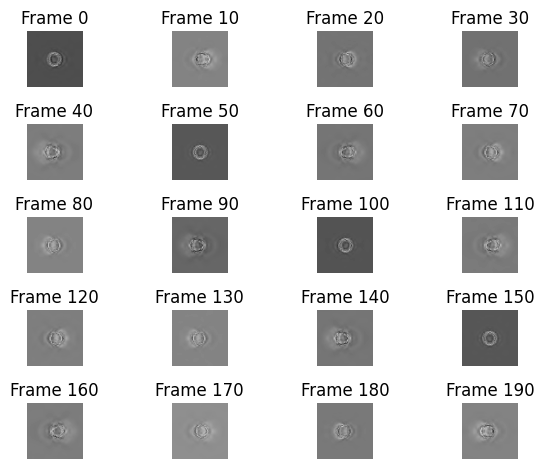

In [ ]:
for i, frame in enumerate(range(0, 200, int(ntp))):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(frames_k5w80[frame], cmap='gray')
    plt.title('Frame {}'.format(frame))
    plt.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

In [ ]:
k= 5 #Magnification
width= 80 # width
frames_k5w80 = magnify_motions_2d(frames, k, width)
animate_cube(frames_k5w80, plot_cbar=False)

Forward DTCWT... DONE
Modifying phase... DONE
Inverse DTCWT... DONE


# Pseudo code
Let us consider what is happening in the motion magnification.
The pseudo code for the algorithm goes something like this:

1. Load in image sequence, ensuring first frame is data[0,:,:]
2. Transform each frame of our video into the DT$\mathbb{C}$WT space. Each image $I^t$ is decomposed into a low pass image $L^t$ and a number of high pass images $H^t_s$ for different spatial scales $s$
> Recall that for each scale/level, the image was decomposed with (2) wavelet(s) in 6 directions to form *complex* coefficients.
We collect all these coefficients into the `pyramid` which has as many elements as there are frames.
3. For each level, calculate the phases from our pyramid of $H^t_s$.
> We actually get the array of *cumulative* angle against time for that scale, which avoids phase discontinuities as 0 $→2\pi$. The formula is $\Phi^t_s(x,y) = \sum_{\tau = 0}^t \phi\left(H^{\tau+1}_s(x,y) / H^{\tau}_s(x,y \right)$.
4. Calculate a phase trend $\overline{\Phi}^t_s$, which is $\Phi^t_s$ smoothed through convolution with a filter of length `w`. This trend will be maintained through the MM, since we need "good" phase information to reconstruct the intensity image.
> The filter used is a flattop filter, not Gaussian or boxcar. The flattop filter is carefully designed to take the most accurate measurement of *signal amplitude* in frequency space (minimal power in scallops, as flat as possible).
5. Now we multiply the high frequency variations of the phase, which is simply the phases minus trend $\Phi^t_s - \overline{\Phi}^t_s$, by the magnification factor ```k```.
> In total we get $\begin{equation} (\Phi_\text{out})^t_s = \overline{\Phi}^t_s + k\left({\Phi}^t_s - \overline{\Phi}^t_s\right) \end{equation}$, so all motions with timescales $\lt$ `w` are amplified.
6. It is important to note **we also smooth the array of phases output $(\Phi_\text{out})^t_s$ by a filter of width 2**. This was found to greatly improve the result of MM on solar data, since high-frequency noise in the phase will also be amplified in the previous step.
> **Of crucial importance:** the oscillation of interest must have a periodicity greater than this smoothing window, else false oscillations may appear. \\
> You can see the effect this phase smoothing alone has by setting your width equal to the length of the data and no magnification, `k=1`, `w=nframes`.)
7. We construct the output high pass images by recombining the (original) absolute values with the new phases, $(H_\text{out})^t_s = |H^t_s| \exp i (\Phi_\text{out})^t_s $.
8. Finally we transform back to get our motion magnified images, combining the modified high pass complex components $H_\text{out}^t$ for all scales $s$ with the low pass image $L^t$.

Note: SA's function ``` phase(pyramids...) ``` will return all numbers with modulus 1 where 0 -> 1. This is to be used for extracting the angles from. Note we do not look at the angles as they evolve over a pyramid level, since this would be moving spatially across one frame. We care about phase changes *temporally* so we must make an array of phases for each scale.

Note 2: now it should be more clear why the magnification of the annulus appears to have an aura-like artefact. The annulus has a steep + poorly resolved jump across the boundary and so is prone to ringing.
I think of it like this: the wave troughs in the low pass image (remember we sacrifice spatial resolution for spectral when using a wavelet) are not sufficiently `filled in' by the high pass components, since we have modified the phases in MM. Had we left the high pass components unchanged, the reconstruction would be perfect despite the low pass appearing ringy.



# Effect of the two frame smoother
The following plot shows the smoother (flattop filter of width 2) used inside the motion magnification routine. This filter is convolved with the array of (cumulative) phases post-magnification, before being transformed back into an image sequence. Note that this mildly denoises the image, since a small incoherent change in the intensity will be spread across the phases at many scales.

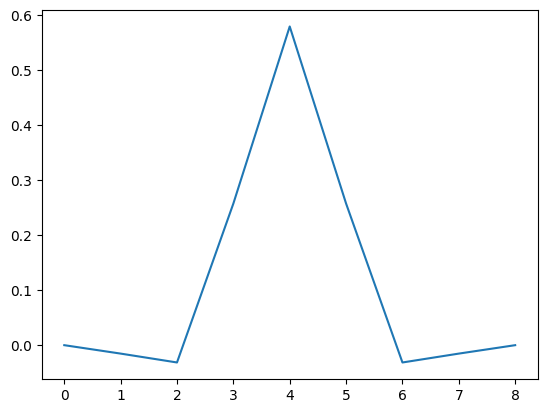

In [ ]:
from scipy import signal
fig, ax = plt.subplots()
window_size =  round(2/0.2327)
window = signal.flattop(window_size)
window = window/np.sum(window)    # Normalise
ax.plot(window)
ax.set_ylabel('Normalised filter amplitude')
ax.set_title('Two-frame (phase) smoother used within MM')

Here we isolate the effect of the 2 frame smoother only.

In [ ]:
k= 1 # No magnification
width = nframes # Set the phase `trend' to be the whole duration. May be some apodisation.
frames_onlysmooth = magnify_motions_2d(frames, k, width)
animate_cube(frames_onlysmooth)

Output hidden; open in https://colab.research.google.com to view.

To finish, let us return to my *gorgeous* dog again! We can motion magnify any video, so why not this video of her sleeping which I took last night. Not creepy at all... \\
First let us animate the original video.

In [ ]:
from IPython.display import HTML
from base64 import b64encode
import os
from google.colab import drive
drive.mount('/content/gdrive')

# Input video path
save_path = "/content/gdrive/MyDrive/daphne_sleeping.mov"

# Compressed video path. Works with mp4, mov etc. Compress since colab sometimes fails if too big.
compressed_path = "/content/gdrive/MyDrive/daphne_sleeping_compressed.mp4"

# Use ffmpeg to convert video
os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


You can see large intensity variations from the light of the TV. Now let us read in the mp4 as a numpy array.

In [ ]:
import cv2

input_video_filename = compressed_path

videoReader = cv2.VideoCapture(input_video_filename)  # create video object
nFrames = int(videoReader.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = int(videoReader.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(videoReader.get(cv2.CAP_PROP_FRAME_HEIGHT))

print("Total Number of Frames = ", nFrames)
print("Each frame has dimensions = ",frameHeight,"x", frameWidth) # Which way around?

# Note we specify float32 since necessary for cv2.color_bgr2gray
img_array_rgb = np.zeros((nFrames, frameHeight,frameWidth, 3), np.dtype("float32"))
img_array = np.zeros((nFrames, frameHeight,frameWidth), np.dtype("float32"))

nf = 0
ret = True

while (nf < nFrames  and ret):  # Could do for loop as well
#		print("frame: " + str(nf))
    ret, img_array_rgb[nf] = videoReader.read()
    img_array[nf] = cv2.cvtColor(img_array_rgb[nf], cv2.COLOR_RGB2GRAY)
    nf += 1
#		if ret == False or img is None:
#				print("done")
#				break

#videoWriter = make_video_writer(videoReader, output_video_filename)

videoReader.release()

Total Number of Frames =  177
Each frame has dimensions =  480 x 480


In [ ]:
animate_cube(img_array)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
daphne_mag = magnify_motions_2d(img_array, 5, 80)

Forward DTCWT... DONE
Modifying phase... DONE
Inverse DTCWT... DONE


In [ ]:
animate_cube(daphne_mag)

Output hidden; open in https://colab.research.google.com to view.

(-0.5, 176.5, 49.5, -0.5)

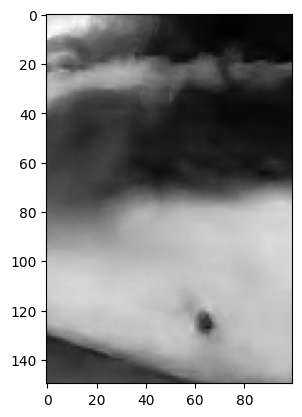

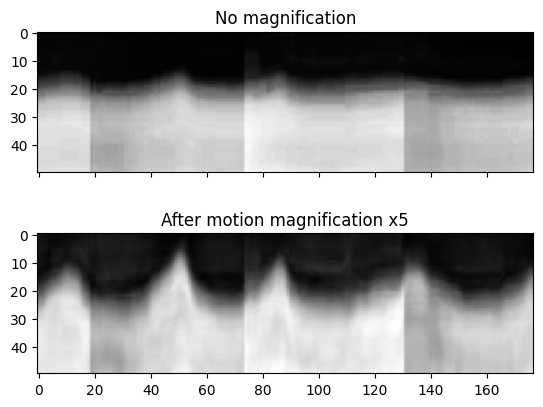

In [ ]:
td_daphne_orig = np.transpose(img_array[:,250:300,400]) # 250:300,400 ~ top of chest. Non-sinusoidal!
td_daphne_mag = np.transpose(daphne_mag[:,250:300,400]) # 200:250,250 ~ through nose. Remarkably still!

plt.figure()
plt.imshow(daphne_mag[0,200:350,350:450], cmap='gray') # [0,200:300,225:275] shows her nose

f, axarr = plt.subplots(2, sharex=True)
axarr[0].imshow(td_daphne_orig, cmap='gray')
axarr[0].set_title('No magnification')
axarr[0].axis("tight")
axarr[0].axis("image")
axarr[1].imshow(td_daphne_mag, cmap='gray')
axarr[1].set_title('After motion magnification x5')
axarr[1].axis("tight")
axarr[1].axis("image")

You can see her breathing is quite non-sinusoidal! Yet her nose is amazingly still.